# Filtro Optimo

## Integrantes
- Martín Sebastian Rodriguez Turco 
- Ian Cruz Díaz
- Agustín Galdeman 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np

import scipy.io.wavfile
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import librosa.display

from pathlib import PurePath
from tqdm.notebook import tqdm

Mounted at /content/drive


## Sonido /a/

### Definición de Funciones:



In [ ]:
from scipy.linalg import toeplitz
from scipy.linalg import solve_toeplitz
from scipy.linalg import inv 
from scipy.linalg import eigvals

#Cálculo correlación
def do_corr(in1, in2):
  r = signal.correlate(in1, in2) / max(len(in1),len(in2))
  return r

#Obtención de error cuadrático mínimo
def compute_Jmin(desired, p, wo):
  desired_energy = np.var(desired)
  Jmin = desired_energy - np.dot(p,wo)
  return Jmin

#Obtengo solución Wiener-Hopf (coeficientes filtros y Jmin)
def solve_wienerhopf(input, desired, M):
  r = do_corr(input, input)
  p = do_corr(input, desired)
  
  # Compute input autocorrelation
  center_r = len(r)//2
  r_M = r[center_r:center_r+M]
  p_center = len(p)//2
  p_M = p[p_center: p_center+M]
  R = toeplitz(r_M)
  
  wo = np.matmul(inv(R), p_M)
  # wo = solve_toeplitz(r_M, p_M)
  Jmin = compute_Jmin(desired, p_M, wo)
  return wo, Jmin

#Convolcuión
def apply_filter(input, wo):
  return signal.convolve(input, wo, mode="same")
  

#Obtención del error de predicción
def estimate_error_filter(wo, u):
  M = len(wo)
  ak = np.zeros(M+1)
  fM = np.zeros(len(u))
  ak[0] = 1   #k=0
  ak[1:] = -wo  #k=1,2,...,M
  
  for n in range(M+1, len(u)):
    fM[n] = np.dot(ak,u[n-M-1:n])
  
  return fM

###Carga de datos

In [ ]:
path_a = PurePath("/content/drive/Shared drives/PASA/TP3 PREDICTOR/Prueba 1/a.wav")
fs, a_wav = scipy.io.wavfile.read(path_a)

#Se asegura un proceso con media cero.
a_wav = a_wav - np.mean(a_wav)
a_wav = a_wav/np.max(np.abs(a_wav))

plt.figure(figsize=(15,5))
plt.title(f"$A$ sound at {fs} Hz")
librosa.display.waveplot(a_wav, sr=fs);

NameError: ignored

In [ ]:
from IPython.display import Audio
Audio(a_wav, rate=fs)

In [ ]:
a_wav_r = np.roll(a_wav, 1)
a_wav_r[0] = 0
desired_a = a_wav_r
input_a = a_wav

###Jmin en función del orden del filtro

In [ ]:
jmins = []
for m in range(1,101):
  wo, Jmin = solve_wienerhopf(input_a, desired_a, m)
  jmins.append(Jmin)

In [ ]:
plt.figure(figsize=(12,9))
plt.grid(which="both");
plt.title('$J_{min}$ en función del orden M')
plt.xlabel('Orden')
plt.ylabel('$J_{min}$')
plt.plot(range(1,101)[2::],jmins[2::]);
plt.scatter(range(1,101)[2::],jmins[2::], marker='o', color='black');

Puede verse que existen saltos abruptos en el gráfico anterior para valores bajos de M. A partir de M cercano a 85 se estabilizan y puede decirse que el error cuadrático medio converge a aun valor cercano a 0.0004. 

###Coeficientes del filtro:

In [ ]:
plt.figure(figsize=(15,5));
plt.title("Coeficientes w0 con orden 100");
plt.grid(which='both')
plt.stem(wo);

###Aplico filtro:

In [ ]:
plt.figure(figsize=(15,5))
a_predicted = apply_filter(input_a, wo)
librosa.display.waveplot(a_predicted, sr=fs);

from IPython.display import Audio
Audio(a_predicted, rate=fs);

###Error de filtrado con diferentes ordenes:






In [ ]:
def plot_psd(signals, fs, Ms):
  plt.figure(figsize=(12,12))
  plt.grid(which='both')

  plt.title('Espectro de señal de error para diferentes filtros')  
  
  for signal, M in zip(signals, Ms):

    signal_asd = np.fft.fft(signal, n=len(signal))

    signal_psd = np.abs(signal_asd)**2
    
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    plt.semilogx(freqs, signal_psd, label=f'M = {M}')

  plt.legend()

In [ ]:
orders = [1, 6, 12, 24, 100]
errors = []

for M in orders:
  wo, Jmin = solve_wienerhopf(input_a, desired_a, M)
  error = estimate_error_filter(wo, input_a)

  plt.figure()
  plt.grid(which="both")
  plt.plot(error)
  plt.title(f'Señal de error para filtro de orden {M}')

  errors.append(error)


###Espectro de señal de error:

In [ ]:
plot_psd(errors, fs, orders)

### Sintetización mediante modelo autoregresivo: 


In [ ]:
#aplico modelo autoregresivo 
def ar(signal, M):
  N = len(signal)
  wo, PM = solve_wienerhopf(signal, desired_a, M)
  
  ak = np.ones(M + 1)
  ak[1:] = -wo

  estimate = np.zeros(len(ak) + N)
  noise = np.random.normal(0, np.sqrt(PM), N + M + 1)


  for n in range(M + 1,N + M + 1):
    estimate[n] = sum([-ak[k] * estimate[n - k] for k in range(M + 1)]) + noise[n]
  
  
  estimate = estimate[M + 1:]

  return estimate

In [ ]:
#se utiliza orden 85 ya que se llega al valor óptimo para sus coeficientes
audio = ar(input_a, 85)

from IPython.display import Audio
Audio(audio, rate=fs)

### Levinson-Durbin:

In [ ]:
#aplico el algoritmo de LEvinson-Durbin, recibo arreglo con coeficientes de correlación y orden del filtro
def Levinson_Durbin(r, M):
  delta = np.zeros(M + 1)
  delta[0]= np.conj(r[1])
  
  P = np.zeros(M + 1)
  P[0] = r[0]

  K = np.zeros(M + 1)

  a = np.zeros((M + 1, M + 1))
  a[0][0] = 1
  
  for m in range(1, M + 1):
      K[m] = -delta[m - 1]/P[m - 1]
      a[m][0] = 1
      
      for k in range(1, m + 1):
        a[m][k] = a[m - 1][k] + K[m]*a[m - 1][m - k]

      delta[m] = r[m + 1] + sum([a[m][k]*r[m + 1 - k] for k in range(1, m + 1)])
      P[m] = P[m - 1]*(1 - K[m]**2)

  return K, P, -a[-1][1:]
  

Coeficientes del filtro mediante Levinson_Durbin:

In [ ]:
#obtengo coeficientes de correlación
u_f = np.fft.fft(input_a)
r = np.fft.ifft(u_f * u_f.conj()).real
r = r[:len(input_a)//2]/len(input_a)

K, P, a = Levinson_Durbin(r, 85)

plt.figure(figsize=(15,5));
plt.title('Coeficientes wo mediante Levinson-Durbin');
plt.grid(which='both');
plt.stem(a);



Coeficientes del filtro utilizando inversion matricial

In [ ]:
wo, Jmin = solve_wienerhopf(input_a, desired_a, 85)
plt.figure(figsize=(15,5));
plt.title('Coeficientes wo mediante Inversión');
plt.grid(which='both');
plt.stem(wo);

Grafico K:

In [ ]:
plt.figure(figsize=(15,5));
plt.title('Coeficientes K');
plt.grid(which='both');
plt.stem(K);

## Sonido /sh/


### Carga de datos

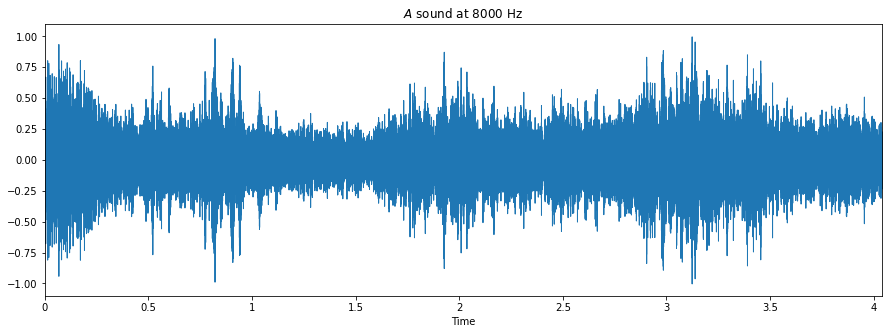

In [ ]:
path_a = PurePath("/content/drive/Shared drives/PASA/TP3 PREDICTOR/Prueba 1/sh.wav")
fs, sh_wav = scipy.io.wavfile.read(path_a)

#Se asegura un proceso con media cero.
sh_wav = sh_wav - np.mean(sh_wav)
sh_wav = sh_wav/np.max(np.abs(sh_wav))

plt.figure(figsize=(15,5))
plt.title(f"$A$ sound at {fs} Hz")
librosa.display.waveplot(sh_wav, sr=fs);

In [ ]:
sh_wav_r = np.roll(sh_wav, 1)
sh_wav_r[0] = 0
desired_a = sh_wav_r
input_a = sh_wav
Audio(sh_wav, rate=fs)

### $J_{min}$ en funcion del orden del filtro

In [ ]:
jmins = []
for m in range(1,101):
  wo, Jmin = solve_wienerhopf(input_a, desired_a, m)
  jmins.append(Jmin)

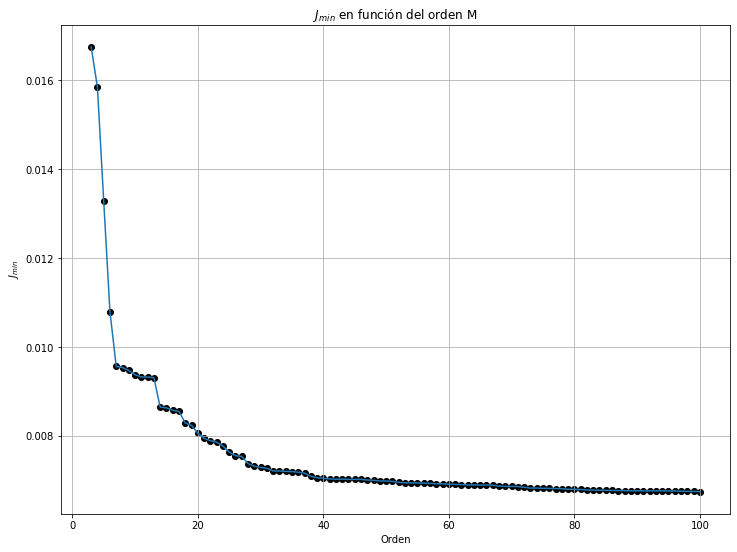

In [ ]:
plt.figure(figsize=(12,9))
plt.grid(which="both");
plt.title('$J_{min}$ en función del orden M')
plt.xlabel('Orden')
plt.ylabel('$J_{min}$')
plt.plot(range(1,101)[2::],jmins[2::]);
plt.scatter(range(1,101)[2::],jmins[2::], marker='o', color='black');

Puede verse que existen saltos abruptos en el gráfico anterior para valores bajos de M. A partir de M cercano a 60 se estabilizan y puede decirse que el error cuadrático medio converge a aun valor cercano a 0.006. 

### Coeficientes del filtro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


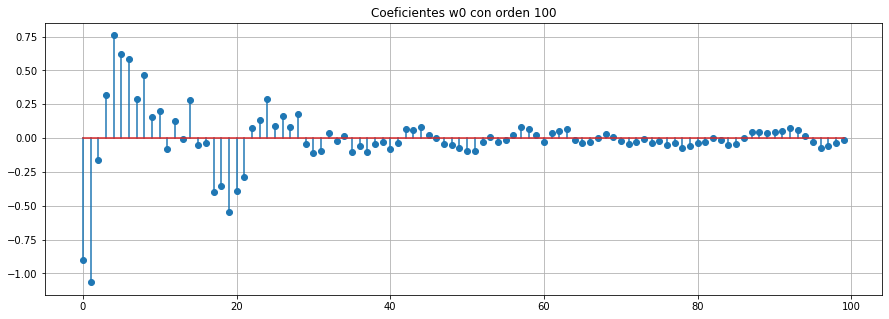

In [ ]:
plt.figure(figsize=(15,5));
plt.title("Coeficientes w0 con orden 100");
plt.grid(which='both')
plt.stem(wo);

### Error de filtrado para diferentes ordenes


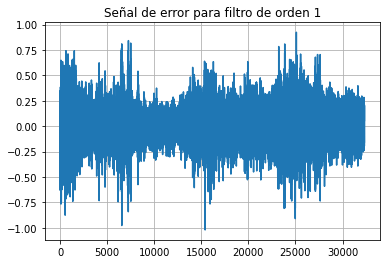

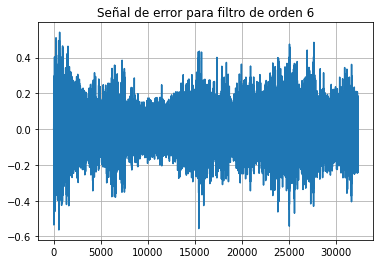

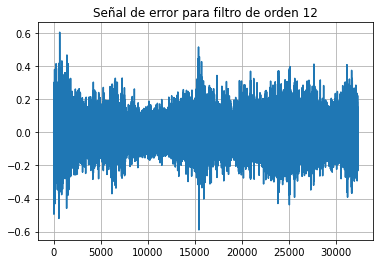

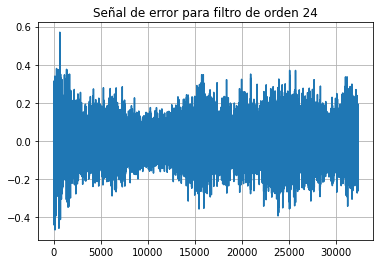

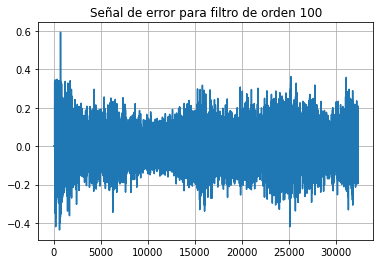

In [ ]:
orders = [1, 6, 12, 24, 100]
errors = []

for M in orders:
  wo, Jmin = solve_wienerhopf(input_a, desired_a, M)
  error = estimate_error_filter(wo, input_a)

  plt.figure()
  plt.grid(which="both")
  plt.plot(error)
  plt.title(f'Señal de error para filtro de orden {M}')

  errors.append(error)

### Espectro de la señal de error

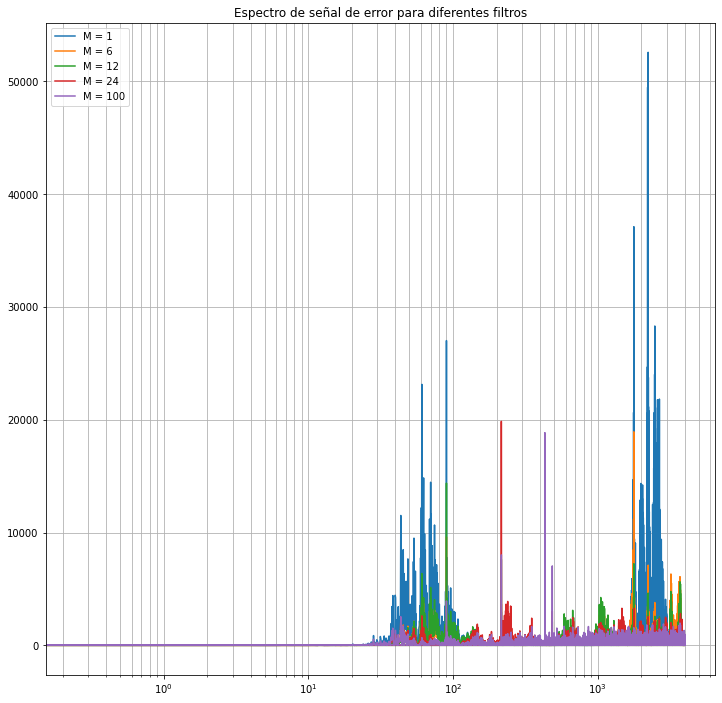

In [ ]:
plot_psd(errors, fs, orders)

### Sintetizacion de modelo autoregresivo

In [ ]:
#se utiliza orden 85 ya que se llega al valor óptimo para sus coeficientes
audio = ar(input_a, 60)

from IPython.display import Audio
Audio(audio, rate=fs)

### Coeficientes del filtro mediante Levinson-Durbin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


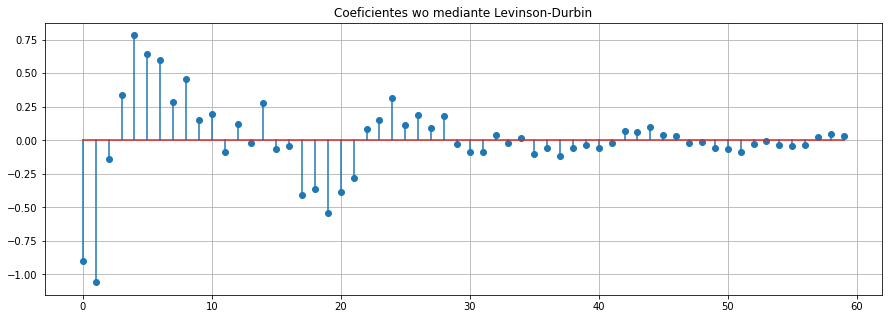

In [ ]:
#obtengo coeficientes de correlación
u_f = np.fft.fft(input_a)
r = np.fft.ifft(u_f * u_f.conj()).real
r = r[:len(input_a)//2]/len(input_a)

K, P, a = Levinson_Durbin(r, 60)

plt.figure(figsize=(15,5));
plt.title('Coeficientes wo mediante Levinson-Durbin');
plt.grid(which='both');
plt.stem(a);

Coeficientes del filtro utilizando inversion matricial

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


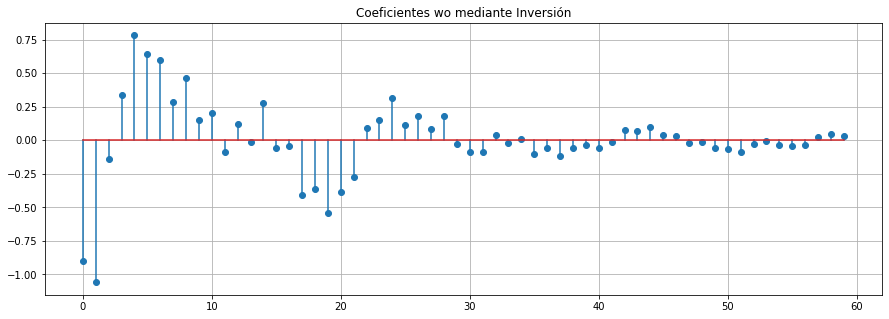

In [ ]:
wo, Jmin = solve_wienerhopf(input_a, desired_a, 60)
plt.figure(figsize=(15,5));
plt.title('Coeficientes wo mediante Inversión');
plt.grid(which='both');
plt.stem(wo);

Grafico los K de Levinson-Durbin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


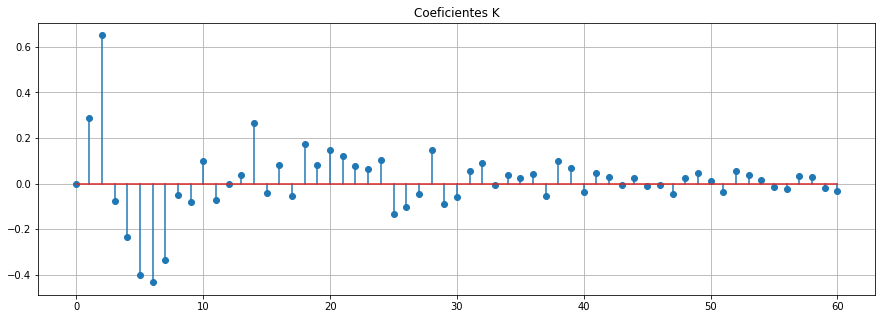

In [ ]:
plt.figure(figsize=(15,5));
plt.title('Coeficientes K');
plt.grid(which='both');
plt.stem(K);